In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


The goal of the company providing the dataset is to prevent click fraud for app developers by measuring the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

We are challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support the modeling, we will observe a dataset covering approximately ~30 million clicks over a range of 4 days.


To make the EDA more efficient, however, we will just sample 1 million clicks from the 30 million provided to us.

In [84]:
df = pd.read_csv('train_sample.csv')
#This is just a 100,000 row sample of the actual training set, which is over a gigabyte. We will evaluate on the sample, before we actually do anything to the real set, for efficiency.
df_test = pd.read_csv('test.csv')
df.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed'],
      dtype='object')

Column values: 

ip: ip address of click, meaning the IP "source" address where a user clicked from (device).

app: app id (each app has 1 id).

device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

os: os version id of user mobile phone

channel: channel id of mobile ad publisher

click_time: timestamp of click (UTC)

attributed_time: if user download the app for after clicking an ad, this is the time of the app download

is_attributed: the target that is to be predicted, indicating the app was downloaded (i.e. Y / Y_hat)

In [37]:
df

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,NaN,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,NaN,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,NaN,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,NaN,0


IMPORTANT NOTE: Atributed_time is only a feature in the training set. Before modelng, drop the feature (or even drop it without doing EDA on it).

In [5]:
df['click_time'].min(), df['click_time'].max()

('2017-11-06 16:00:00', '2017-11-09 15:59:51')

Time being measured here is a 4 day period. Any sort of Time Series analyses will probably be best done per hour

In [6]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


Notes: All of the int types are nominal data. For some of them, one hot encoding will be required for the models. Also, to do time series analysis, we will need to convert the click time from an object, to a datetime object.


In [8]:
nominal = [x for x in df.columns if df[x].dtype == 'int64'][:-1] #get rid of last column, which is the target
time_series = [x for x in df.columns if df[x].dtype == 'object']
downloads = df.columns[-1]


Downloads vs. Non- Downloads

Text(0.5, 0, 'Downloaded')

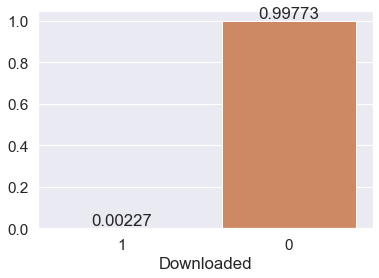

In [38]:
mean = (df.is_attributed.values==1).mean()
ax = sns.barplot(x =['1', '0'], y =[mean, 1-mean])
ax.bar_label(ax.containers[0]);
plt.xlabel('Downloaded')

Significantly more downloads than non dowloads-- labeling imbalance

### Coorelation of Features to Downloads

We can try looking to see if individual features have unique coorelation to eventual downloads: Lets start by checking device.

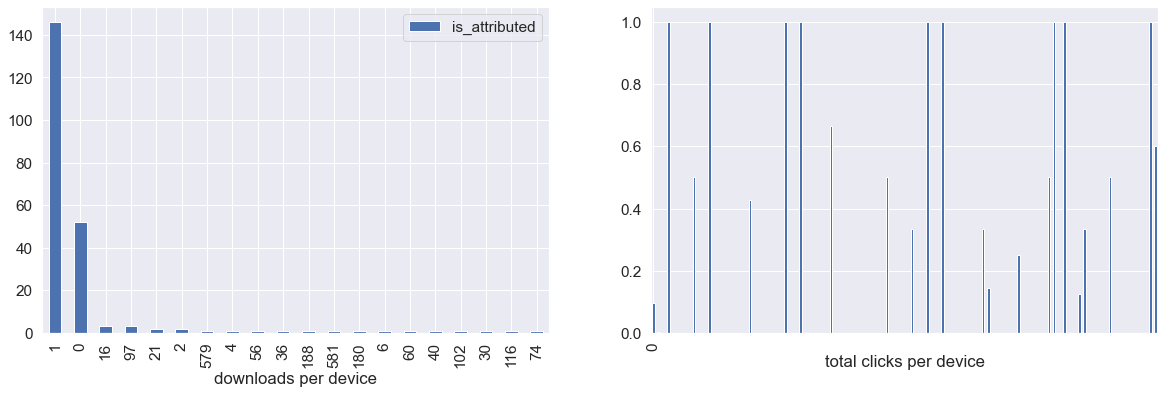

In [45]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
t = df.copy()
t['device'] = t['device'].astype(str)
t.groupby('device').sum()[['is_attributed']].sort_values('is_attributed', ascending= False).head(20).plot(kind = 'bar', ax = plt.gca())
plt.xlabel('downloads per device')

plt.subplot(1,2,2)
(t.groupby('device')['is_attributed'].sum() / t.groupby('device')['is_attributed'].size()).plot(kind = 'bar', ax = plt.gca())
plt.xlabel('total clicks per device')
plt.xticks([0],[0]);

Initially we might assume from the graph on the left, that some devices are highly coorelated with eventual download. However, when factoring in the amount of traffic those devices get in general, we can see how this might just be a result of an imbalance in the amount of clicks attributed to those devices-- perhaps they in general are more popular devices.

However, we can still plot the distributions of the features, and how much traffic they get for each individual item in their category, to get a general sense for the data. For examle, we can see how there are higher amounts of click counts for more unique channels, than there are for different devices or different apps.

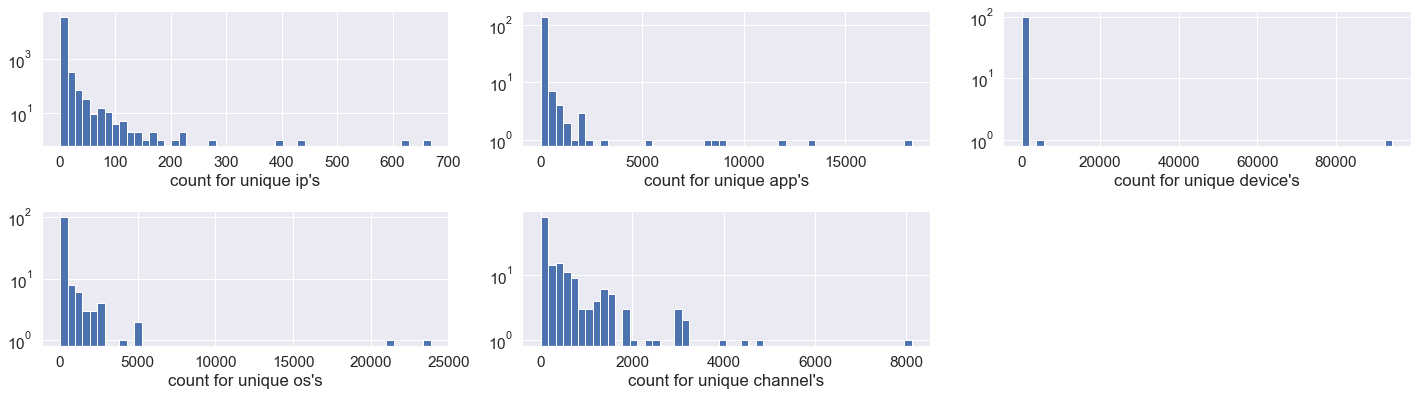

In [13]:
cols = ['ip', 'app', 'device', 'os', 'channel']
fig = plt.figure(figsize = (20,8))
for i, col in enumerate(cols):
    plt.subplot(3,3,i+1)
    plt.hist(df.groupby(col)['click_time'].count(), bins = 50);
    plt.yscale('log')
    plt.xlabel(f'count for unique {col}\'s')
plt.tight_layout()

To get a better sense of feature coorelation to downloads, lets try copmaring their unique values to their priors, and get probabbilities for each feature of ending up with a download:

In [58]:
total = len(df.ip.unique())
conversions = df.groupby('ip')['is_attributed'].any()
converted_ips = len(conversions[conversions == 1])
print('total amount of unique ip addresses', total)
print('total amount of unique ip addresses which eventually downloaded: ', converted_ips)
print('total percent of ip addresses which had any downloadeds: ', converted_ips/total *100, '%')

total amount of unique ip addresses 34857
total amount of unique ip addresses which eventually downloaded:  223
total percent of ip addresses which had any downloadeds:  0.6397567203144275 %


In [83]:
for col in df.columns[:-2]:
    total = len(df[col].unique())
    conversions = df.groupby(col)['is_attributed'].any()
    converted = len(conversions[conversions == 1])
    y = df.groupby(col)['is_attributed'].sum()
    always = len(y[y==1])
    never = len(y[y==0])

    print('total amount of unique', col, ': ', total)
    print('total amount of unique', col, 'which eventually downloaded: ', converted)
    print('total percent of unique', col, 'which had any downloadeds: ', converted/total *100, '%')
    print('total percent of ', col, 'which always downloaded: ', always / total *100, ' %')
    print('total percent of ', col, 'which never downloaded: ', never / total *100, ' %')

    print('\n')

total amount of unique ip :  34857
total amount of unique ip which eventually downloaded:  223
total percent of unique ip which had any downloadeds:  0.6397567203144275 %
total percent of  ip which always downloaded:  0.6340189918811143  %
total percent of  ip which never downloaded:  99.36024327968556  %


total amount of unique app :  161
total amount of unique app which eventually downloaded:  37
total percent of unique app which had any downloadeds:  22.981366459627328 %
total percent of  app which always downloaded:  9.937888198757763  %
total percent of  app which never downloaded:  77.01863354037268  %


total amount of unique device :  100
total amount of unique device which eventually downloaded:  25
total percent of unique device which had any downloadeds:  25.0 %
total percent of  device which always downloaded:  19.0  %
total percent of  device which never downloaded:  75.0  %


total amount of unique os :  130
total amount of unique os which eventually downloaded:  39
tota

This is really good information. There are large amount of unique values in each feature that never convert to donwloads, and relatively small amounts of values which always or sometimes convert to downloads (especially for the ip addresses, which have less than 1% of unique Ip's convert to downloads). This indicates that combinations of features could give great probabilities of if a download will occur

### TimeSeries

Lets check to see if there are any patterns, or anomalies in those patterns, for click traffic.

Feature Extraction

In [19]:
df['click_time'] = pd.to_datetime(df.click_time, dayfirst= True)

In [20]:
df['day'] = df['click_time'].dt.day.astype('uint8')
df['hour'] = df['click_time'].dt.hour.astype('uint8')
df['min'] = df['click_time'].dt.minute.astype('uint8')
df['sec'] = df['click_time'].dt.second.astype('uint8')

In [21]:
d = df.set_index('click_time')
daily_clicks = d.resample('H').size()/np.sum(d.resample('H').size())
daily_clicks

click_time
2017-11-06 16:00:00    0.01192
2017-11-06 17:00:00    0.00717
2017-11-06 18:00:00    0.00414
2017-11-06 19:00:00    0.00298
2017-11-06 20:00:00    0.00235
                        ...   
2017-11-09 11:00:00    0.01763
2017-11-09 12:00:00    0.01790
2017-11-09 13:00:00    0.01935
2017-11-09 14:00:00    0.01851
2017-11-09 15:00:00    0.01654
Freq: H, Length: 72, dtype: float64

<AxesSubplot:xlabel='click_time'>

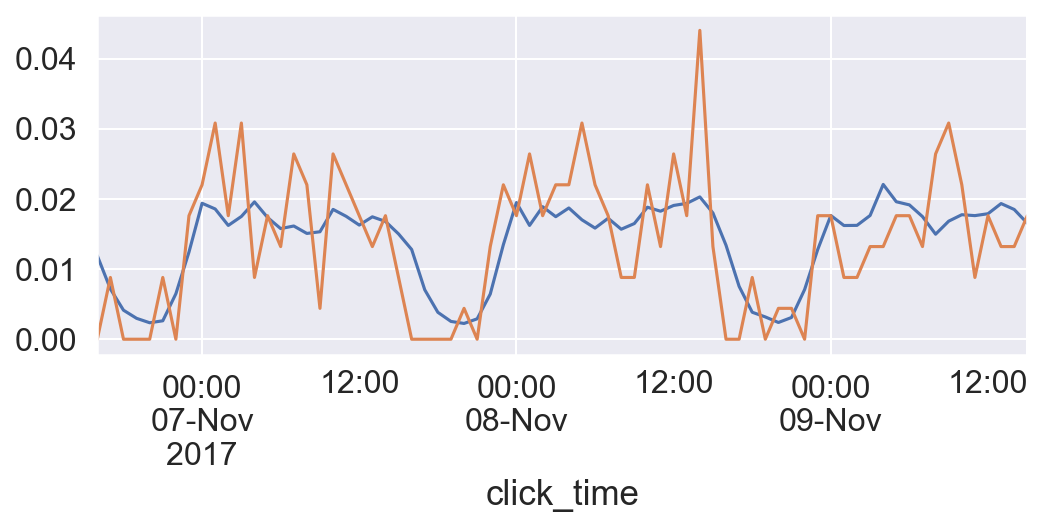

In [22]:

plt.figure(figsize=(8,3) , dpi=150)  

daily_clicks = d.resample('H').size()/np.sum(d.resample('H').size())
daily_clicks.plot()

daily_dow = d.resample('H')['is_attributed'].sum()/ np.sum(d.resample('H')['is_attributed'].sum())
daily_dow.plot()

Text(0.5, 1.0, 'aggregate clicks by hour')

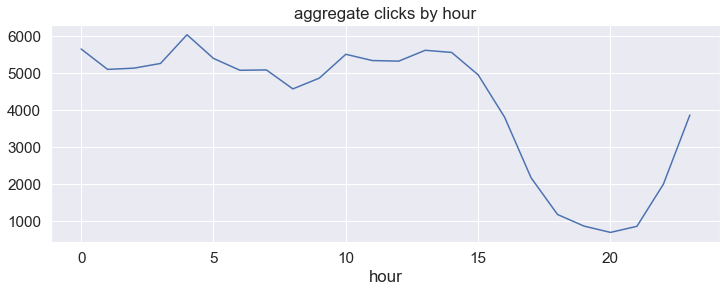

In [23]:
fig = plt.figure(figsize= (12,4))
df.groupby('hour').count()['click_time'].plot()
plt.title('aggregate clicks by hour')


Text(0.5, 1.0, 'aggregate clicks per day')

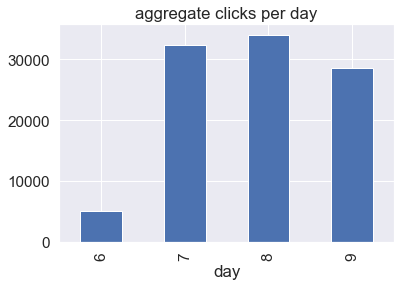

In [24]:
df.groupby('day').count()['click_time'].plot(kind = 'bar')
plt.title('aggregate clicks per day')

The clicks follow a steady rate and pattern throughout the 4 day period. From midnight until around 4pm, there is high clicking traffic. From early afternoon until early night there is a steep decline, and then rises back up quickly later in the night.

However, we see that the amount of downloads, however variable they may be, also follow a  similar pattern

Since there isn't much variation from day to day, we could do feature extraction and pull out the hours and minutes, and aggregate by them ot better view the data

### Further Feature Extraction:

For this data set, it will be important to extract features based on events up until a certain point (either in time, or amount of clicks, etc.). This is because, we want to be able to produce, based off a given amount of usage, if that click will eventually be converted into a download, or not.

In [27]:
full_session = df.groupby(['ip'])['click_time'].count().to_frame('click_size')
full_session['downloaded'] = df.groupby(['ip'])['is_attributed'].any().astype(int)
full_session

,click_size,downloaded
ip,,
9,1,0
10,3,0
19,1,0
20,4,0
25,1,0
...,...,...
364515,1,0
364621,1,0
364630,1,0


In [28]:
full_analysis = full_session.groupby('click_size')['click_size'].count().to_frame('amount_of_clicks')
full_analysis['download_ratio'] = full_session.groupby('click_size')['downloaded'].mean()
full_analysis.head(10)


,amount_of_clicks,download_ratio
click_size,,
1,17423,0.008609
2,7089,0.003527
3,3611,0.001939
4,1982,0.002523
5,1201,0.007494
6,819,0.001221
7,590,0.003390
8,463,0.006479
9,363,0.005510


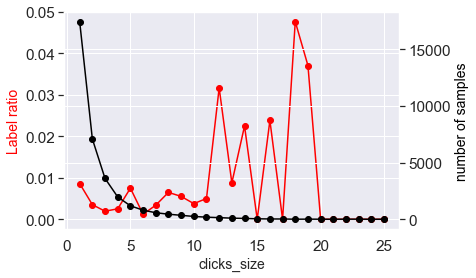

In [29]:
fig,ax = plt.subplots()
# make a plot
full_analysis['download_ratio'][:25].plot.line(ax = ax,color="red",marker="o")
ax.set_xlabel("clicks_size",fontsize=14)
ax.set_ylabel("Label ratio",color="red",fontsize=14)
ax2=ax.twinx()
full_analysis['amount_of_clicks'][:25].plot.line(ax = ax2,color="black",marker="o")
ax2.set_ylabel("number of samples",color="black",fontsize=14)
plt.show()

The amount of clicks per session, doesn't seem to tell us much about the ratio of clicks to downloads